In [17]:
# This block is for initialiizing our language model
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="qwen2.5-coder:14b",
    temperature=0,
    # other params...
)

In [18]:
# This block is for initialiizing our connection to our database
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


'[(8,)]'

In [19]:
# This block is for initializing our agent functions
from typing_extensions import TypedDict
from langchain import hub
from typing_extensions import Annotated
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

# example write query
write_query({"question": "How many Employees are there?"})

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

# example execute query
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

/home/bear-bissen/miniconda3/envs/researcher/lib/python3.10/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


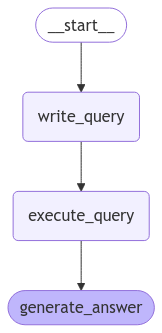

In [20]:
# Define, Compile, and Visualize the Graph
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

#write_query({"question": "How many Employees are there?"})
#execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
# Now lets test out our graph
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM EMPLOYEE;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


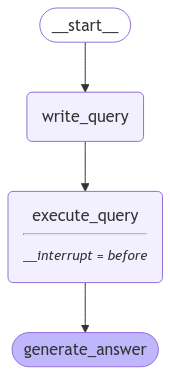

In [22]:
# Next up is the human in the loop version of the graph with memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) FROM EMPLOYEE;'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


In [24]:
# Now going to define a SQL agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain import hub
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

# prepare the SQL database toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
tools

# prepare the system prompt
prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
assert len(prompt_template.messages) == 1
prompt_template.messages[0].pretty_print()
system_message = prompt_template.format(dialect="SQLite", top_k=5)

# initalize the agent executor
agent_executor = create_react_agent(llm, tools, state_modifier=system_message)

/home/bear-bissen/miniconda3/envs/researcher/lib/python3.10/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [25]:
# Test out the Sql agent
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (a2fc8fc7-827f-4fba-8ca2-a8f7ef6ff246)
 Call ID: a2fc8fc7-827f-4fba-8ca2-a8f7ef6ff246
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (3aa7d8c3-1429-4784-9f66-9a604bb4f812)
 Call ID: 3aa7d8c3-1429-4784-9f66-9a604bb4f812
  Args:
    table_names: Invoice,Customer
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"L

In [26]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (e0db0198-c01c-4445-989f-343573d175b3)
 Call ID: e0db0198-c01c-4445-989f-343573d175b3
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (f8277c32-9133-4c09-adff-f8b8405c240f)
 Call ID: f8277c32-9133-4c09-adff-f8b8405c240f
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("Pl

In [37]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['Walking Into Clarksdale',
 'Beethoven: Symhonies Nos.  &',
 'Mezmerize',
 'Carry On',
 'Handel: The Messiah (Highlights)']

In [28]:
# This block is for initializing our embeddings model
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="granite-embedding:30m")

In [40]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain.agents.agent_toolkits import create_retriever_tool

# Vectorize a sample query
vector_1 = embeddings.embed_query(artists[0])
vector_2 = embeddings.embed_query(albums[0])

# assert and inspect the the vector length
assert len(vector_1) == len(vector_2)
dimension = len(vector_1)
print(f"Generated vectors of length {dimension}\n")
print(vector_1[:10])

# Initialize vector store
index = faiss.IndexFlatL2(dimension)
vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

# Add the texts to the vector store and initialize the retriever
_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

Generated vectors of length 384

[0.05152956, 0.0069452464, -0.01328757, 0.007548544, -0.0014913678, -0.05413562, -0.052966963, -0.06148111, -0.049378213, -0.029824253]


In [39]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Ace Of Spades

Allegri: Miserere

Purcell: The Fairy Queen

Cake: B-Sides and Rarities


In [42]:
# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, state_modifier=system)

In [43]:
question = "How many albums does alis in chain have?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many albums does alis in chain have?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (4c70bcb5-f4a5-47e9-9f5d-f8258d450c06)
 Call ID: 4c70bcb5-f4a5-47e9-9f5d-f8258d450c06
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (7db1e479-31dd-4c97-a7e4-9cafbd2934b0)
 Call ID: 7db1e479-31dd-4c97-a7e4-9cafbd2934b0
  Args:
    table_names: Album, Artist
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTE